In [1]:
import sys
sys.path.append('./lib')

In [2]:
import numpy as np
import cv2
# import tensorflow as tf
import os 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)  

In [3]:
!which python

/usr/bin/python


In [4]:
np.set_printoptions(precision=3)

### Dataset

In [5]:
# import datasets
import os
import time
import PIL
import datasets.imdb
import numpy as np
import scipy.sparse
from utils.cython_bbox import bbox_overlaps
from utils.boxes_grid import get_boxes_grid
import subprocess
import cPickle
from fast_rcnn.config import cfg
import math
from rpn_msr.generate_anchors import generate_anchors_bv
from utils.transform import camera_to_lidar_cnr, lidar_to_corners_single, computeCorners3D, lidar_cnr_to_3d

In [79]:
from utils.transform import corners_to_bv

In [80]:
from utils.transform import camera_to_lidar_cnr

In [81]:
from datasets.kitti_mv3d import kitti_mv3d

In [82]:
def camera_to_lidar_cnr(pts_3D, P):
    """
    convert camera corners to lidar corners
    """
    if pts_3D.shape[1] == 24:
        pts_3D = pts_3D.reshape((3, 8))
        
    pts_3D = np.vstack((pts_3D, np.zeros(8)))

    assert pts_3D.shape == (4, 8)

    R = np.linalg.inv(P[:, :3])
    # T = -P[:, 3].reshape((3, 1))
    T = np.zeros((3, 1))
    T[0] = -P[1,3] 
    T[1] = -P[2,3]
    T[2] = P[0,3]
    RT = np.hstack((R, T))

    lidar_corners = np.dot(RT, pts_3D)
    lidar_corners = lidar_corners[:3,:]

    return lidar_corners.reshape(-1, 24)

In [83]:
kitti = kitti_mv3d('train')

<bound method kitti_mv3d.default_roidb of <datasets.kitti_mv3d.kitti_mv3d object at 0x7ff6fb195e50>>


In [84]:
kitti_roidb = kitti.roidb

train gt roidb loaded from /home/radmin/code/Faster-RCNN_TF/data/cache/train_gt_roidb.pkl


#### Data Visualize

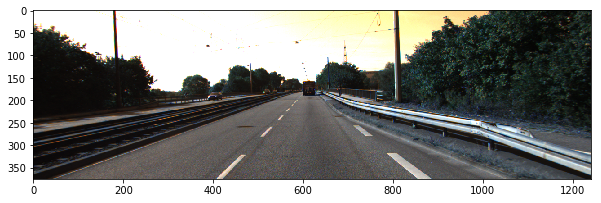

In [94]:
test_image = cv2.imread(kitti.image_path_at(1))
plt.imshow(test_image)

In [88]:
kitti_roidb[0].keys()

['alphas',
 'gt_classes',
 'boxes_3D',
 'xyz',
 'lwh',
 'ry',
 'flipped',
 'boxes',
 'boxes_3D_cam',
 'boxes_corners',
 'boxes_bv',
 'boxes3D_cam_corners',
 'gt_overlaps']

In [95]:
kitti_roidb[1]

{'alphas': array([ 1.85], dtype=float32),
 'boxes': array([[ 387.63,  181.54,  423.81,  203.12]], dtype=float32),
 'boxes3D_cam_corners': array([[-15.594, -17.464, -17.466, -15.596, -15.594, -17.464, -17.466,
         -15.596,   2.39 ,   2.39 ,   2.39 ,   2.39 ,   0.72 ,   0.72 ,
           0.72 ,   0.72 ,  56.646,  56.644,  60.334,  60.336,  56.646,
          56.644,  60.334,  60.336]], dtype=float32),
 'boxes_3D': array([[ 58.38 ,  16.971,  -0.679,   3.69 ,   1.87 ,   1.67 ]], dtype=float32),
 'boxes_3D_cam': array([[-16.53,   2.39,  58.49,   3.69,   1.87,   1.67]], dtype=float32),
 'boxes_bv': array([[ 221.,  101.,  240.,  138.]], dtype=float32),
 'boxes_corners': array([[ 56.556,  56.54 ,  60.23 ,  60.245,  56.531,  56.516,  60.205,
          60.221,  16.021,  17.891,  17.922,  16.052,  16.02 ,  17.89 ,
          17.92 ,  16.051,  -1.541,  -1.54 ,  -1.486,  -1.487,   0.128,
           0.13 ,   0.184,   0.183]], dtype=float32),
 'flipped': False,
 'gt_classes': array([1], dtype=int3

In [96]:
kitti_roidb[1]['boxes_3D_cam']

array([[-16.53,   2.39,  58.49,   3.69,   1.87,   1.67]], dtype=float32)

In [129]:
# in 
xyzs = [bb['boxes_3D_cam'] for bb in kitti_roidb if np.any(bb['boxes_3D_cam'])]
xyzs = np.array(xyzs)
print xyzs.shape


(4447,)


IndexError: too many indices for array

In [134]:
xyzs = np.ones(6)
for bb in kitti_roidb:
    if np.any(bb['boxes_3D_cam']):
        xyzs = np.vstack((xyzs, bb['boxes_3D_cam']))
print xyzs.shape

(19082, 6)


In [136]:
xs = xyzs[:,0]
ys = xyzs[:,1]
zs = xyzs[:,2]

In [154]:
len(np.where((xs < -40) | (xs > 40) )[0])

2

In [150]:
zs

array([  1.  ,  58.49,  34.38, ...,  18.52,  23.92,  35.07])

In [161]:
len(np.where((zs > 60))[0])

867

(array([  2.000e+00,   4.000e+00,   4.000e+00,   7.700e+01,   1.500e+02,
          5.200e+02,   6.760e+02,   1.084e+03,   3.056e+03,   4.940e+03,
          2.610e+03,   4.232e+03,   7.390e+02,   3.650e+02,   2.330e+02,
          2.410e+02,   1.170e+02,   2.800e+01,   0.000e+00,   4.000e+00]),
 array([-43.58 , -39.408, -35.236, -31.064, -26.892, -22.72 , -18.548,
        -14.376, -10.204,  -6.032,  -1.86 ,   2.312,   6.484,  10.656,
         14.828,  19.   ,  23.172,  27.344,  31.516,  35.688,  39.86 ]),
 <a list of 20 Patch objects>)

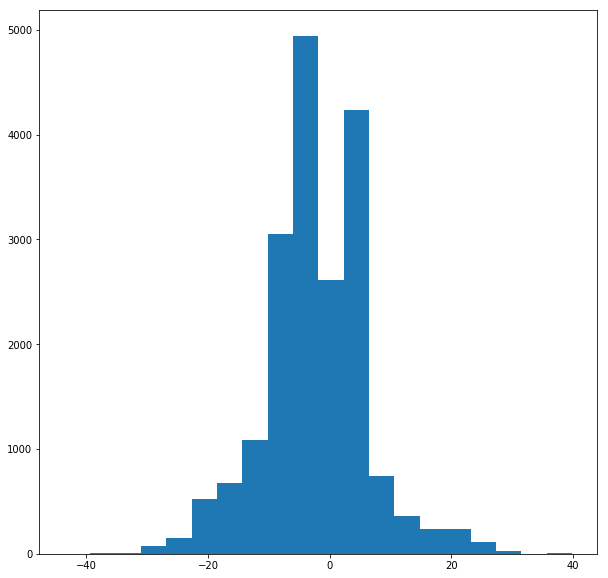

In [139]:
plt.hist(xs, bins=20)

(array([  1.000e+00,   1.000e+00,   1.000e+00,   2.000e+00,   4.000e+00,
          1.800e+01,   5.000e+01,   7.700e+01,   1.560e+02,   3.350e+02,
          1.097e+03,   4.119e+03,   8.775e+03,   3.125e+03,   9.030e+02,
          2.690e+02,   1.130e+02,   2.600e+01,   5.000e+00,   5.000e+00]),
 array([-2.14 , -1.829, -1.517, -1.206, -0.894, -0.583, -0.271,  0.04 ,
         0.352,  0.664,  0.975,  1.287,  1.598,  1.91 ,  2.221,  2.533,
         2.844,  3.156,  3.467,  3.779,  4.09 ]),
 <a list of 20 Patch objects>)

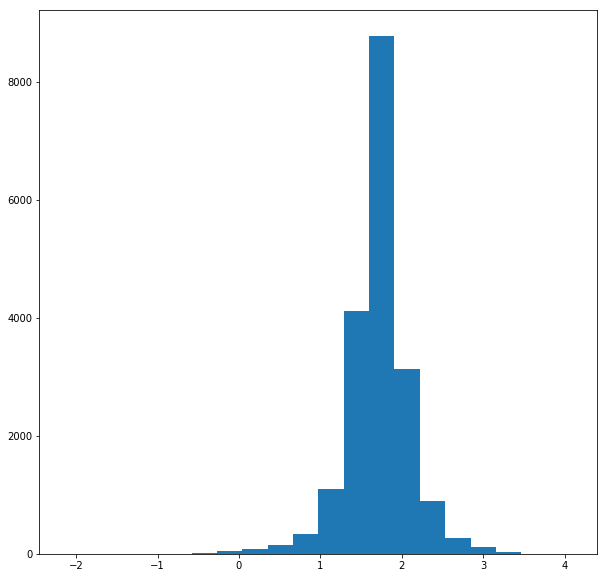

In [140]:
plt.hist(ys, bins=20)

(array([  5.980e+02,   1.427e+03,   1.738e+03,   1.921e+03,   1.992e+03,
          2.103e+03,   1.728e+03,   1.606e+03,   1.369e+03,   1.105e+03,
          9.200e+02,   7.240e+02,   6.140e+02,   4.040e+02,   3.100e+02,
          2.020e+02,   1.680e+02,   1.160e+02,   3.500e+01,   2.000e+00]),
 array([  0.18,   4.48,   8.78,  13.08,  17.38,  21.68,  25.98,  30.28,
         34.58,  38.88,  43.18,  47.48,  51.78,  56.08,  60.38,  64.68,
         68.98,  73.28,  77.58,  81.88,  86.18]),
 <a list of 20 Patch objects>)

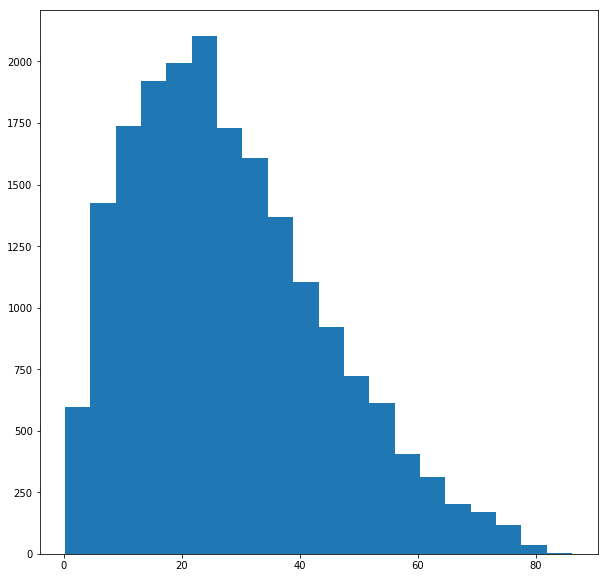

In [141]:
plt.hist(zs, bins=20)

#### TEST corners

In [12]:
kitti.image_path_at(8)

'./lib/datasets/../../data/KITTI/object/training/image_2/000008.png'

In [13]:
kitti.lidar_path_at(8)

'./lib/datasets/../../data/KITTI/object/training/lidar_bv/000008.npy'

In [29]:
test_lidar = np.load(kitti.lidar_path_at(38))
test_image = cv2.imread(kitti.image_path_at(38))

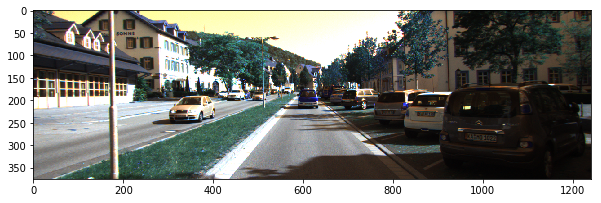

In [30]:
plt.imshow(test_image)

In [31]:
test_lidar2 = np.zeros((test_lidar.shape[0], test_lidar.shape[1]))
for i in range(24):
    inds = np.where(test_lidar[:,:,i] != 0)
    test_lidar2[inds] = 1

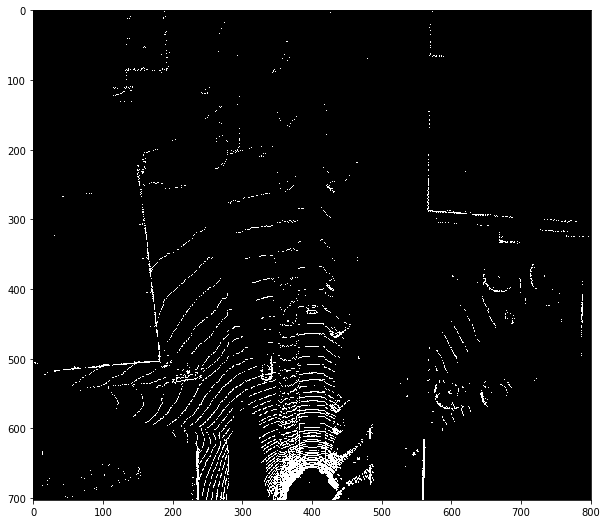

In [32]:
plt.imshow(test_lidar2, cmap='gray')

In [19]:
gt_bv = kitti.roidb[8]['boxes_bv']

In [20]:
test = np.copy(test_lidar2)
num = len(gt_bv)
for n in range(num):
    x1,y1,x2,y2 = gt_bv[n]
    cv2.rectangle(test,(x1,y1), (x2,y2), (0,255,0), 2)

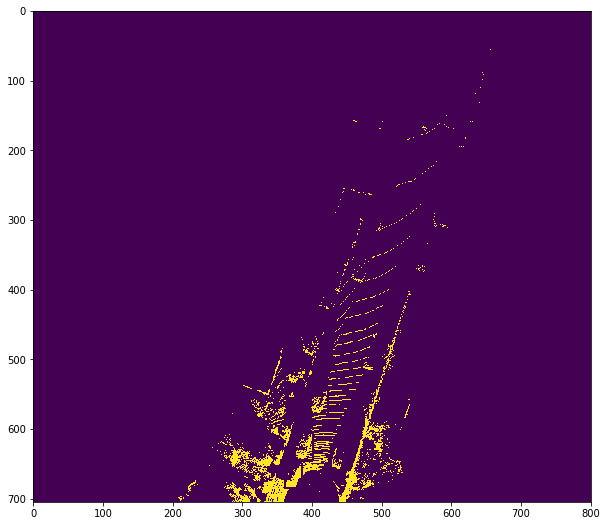

In [21]:
plt.imshow(test)#, cmap='gray')

In [23]:
def corners_to_img(corners, Tr, R0, P2):
    
    Tr = Tr.reshape((3, 4))
    R0 = R0.reshape((3, 3))
    P2 = P2.reshape((3, 4))
    
    if 24 in corners.shape:
        corners = corners.reshape((3, 8))

    RO = np.vstack((R0, np.zeros(3)))
    corners = np.vstack((corners, np.zeros(8)))

    mat1 =  np.dot(P2, RO)
    mat2 = np.dot(mat1, Tr)
    img_cor = np.dot(mat2, corners)
    return img_cor

In [24]:
calib = kitti._load_kitti_calib('000008')
print calib

{'P2': array([[  7.21537720e+02,   0.00000000e+00,   6.09559326e+02,
          4.48572807e+01],
       [  0.00000000e+00,   7.21537720e+02,   1.72854004e+02,
          2.16379106e-01],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          2.74588400e-03]], dtype=float32), 'P3': array([[  7.21537720e+02,   0.00000000e+00,   6.09559326e+02,
         -3.39524200e+02],
       [  0.00000000e+00,   7.21537720e+02,   1.72854004e+02,
          2.19993591e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          2.72990507e-03]], dtype=float32), 'R0': array([[ 0.99992388,  0.00983776, -0.00744505],
       [-0.0098698 ,  0.99994212, -0.00427846],
       [ 0.00740253,  0.00435161,  0.9999631 ]], dtype=float32), 'Tr_velo2cam': array([[  7.53374491e-03,  -9.99971390e-01,  -6.16602018e-04,
         -4.06976603e-03],
       [  1.48024904e-02,   7.28073297e-04,  -9.99890208e-01,
         -7.63161778e-02],
       [  9.99862075e-01,   7.52379000e-03,   1.48075502e-0

In [17]:
calib2[3]

array([  7.53374491e-03,  -9.99971390e-01,  -6.16602018e-04,
        -4.06976603e-03,   1.48024904e-02,   7.28073297e-04,
        -9.99890208e-01,  -7.63161778e-02,   9.99862075e-01,
         7.52379000e-03,   1.48075502e-02,  -2.71780610e-01])

In [16]:
calib2 = kitti.calib_at(8)
print calib2

[[  7.21537720e+02   0.00000000e+00   6.09559326e+02   4.48572807e+01
    0.00000000e+00   7.21537720e+02   1.72854004e+02   2.16379106e-01
    0.00000000e+00   0.00000000e+00   1.00000000e+00   2.74588400e-03]
 [  7.21537720e+02   0.00000000e+00   6.09559326e+02  -3.39524200e+02
    0.00000000e+00   7.21537720e+02   1.72854004e+02   2.19993591e+00
    0.00000000e+00   0.00000000e+00   1.00000000e+00   2.72990507e-03]
 [  9.99923885e-01   9.83775966e-03  -7.44504808e-03  -9.86979529e-03
    9.99942124e-01  -4.27845912e-03   7.40252715e-03   4.35161404e-03
    9.99963105e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  7.53374491e-03  -9.99971390e-01  -6.16602018e-04  -4.06976603e-03
    1.48024904e-02   7.28073297e-04  -9.99890208e-01  -7.63161778e-02
    9.99862075e-01   7.52379000e-03   1.48075502e-02  -2.71780610e-01]]


In [40]:
def drawBox3D(img, corners):
    
#     img = np.copy(img)
    corners = corners.astype(np.int32)

    cv2.line(img, (corners[0,0], corners[1,0]), (corners[0,1], corners[1,1]), thickness=2, color=(0, 255, 255))
    cv2.line(img, (corners[0,1], corners[1,1]), (corners[0,2], corners[1,2]), thickness=2, color=(0, 255, 255))
    cv2.line(img, (corners[0,2], corners[1,2]), (corners[0,3], corners[1,3]), thickness=2, color=(0, 255, 255))
    cv2.line(img, (corners[0,3], corners[1,3]), (corners[0,0], corners[1,0]), thickness=2, color=(0, 255, 255))

    cv2.line(img, (corners[0,4], corners[1,4]), (corners[0,5], corners[1,5]), thickness=2, color=(0, 255, 255))
    cv2.line(img, (corners[0,5], corners[1,5]), (corners[0,6], corners[1,6]), thickness=2, color=(0, 255, 255))
    cv2.line(img, (corners[0,6], corners[1,6]), (corners[0,7], corners[1,7]), thickness=2, color=(0, 255, 255))
    cv2.line(img, (corners[0,7], corners[1,7]), (corners[0,4], corners[1,4]), thickness=2, color=(0, 255, 255))

    cv2.line(img, (corners[0,0], corners[1,0]), (corners[0,4], corners[1,4]), thickness=2, color=(0, 255, 255))
    cv2.line(img, (corners[0,1], corners[1,1]), (corners[0,5], corners[1,5]), thickness=2, color=(0, 255, 255))
    cv2.line(img, (corners[0,2], corners[1,2]), (corners[0,6], corners[1,6]), thickness=2, color=(0, 255, 255))
    cv2.line(img, (corners[0,3], corners[1,3]), (corners[0,7], corners[1,7]), thickness=2, color=(0, 255, 255))

    return img

In [41]:
def projectToImage(pts_3D, P):

    """ 
    PROJECTTOIMAGE projects 3D points in given coordinate system in the image
    plane using the given projection matrix P.

    Usage: pts_2D = projectToImage(pts_3D, P)
    input: pts_3D: 3xn matrix
          P:      3x4 projection matrix
    output: pts_2D: 2xn matrix

    last edited on: 2012-02-27
    Philip Lenz - lenz@kit.edu 
    """
    # project in image
    mat = np.vstack((pts_3D, np.ones((pts_3D.shape[1]))))

    pts_2D = np.dot(P, mat)
    # print(pts_2D)

    # scale projected points
    pts_2D[0,:] = pts_2D[0,:] / pts_2D[2,:]
    pts_2D[1,:] = pts_2D[1,:] / pts_2D[2,:]
    pts_2D = np.delete(pts_2D, 2, 0)
    # pts_2D[2,:] = np.zeros(())
    return pts_2D

### test camera cnr to lidar cnrs

In [42]:
def camera_to_lidar_cnr(pts_3D, P):
    """
    convert camera(x, y, z, l, w, h) to lidar (x, y, z, l, w, h)
    """
    if pts_3D.shape[1] == 24:
        pts_3D = pts_3D.reshape((3, 8))
        
    pts_3D = np.vstack((pts_3D, np.zeros(8)))

    R = np.linalg.inv(P[:, :3])
    # T = -P[:, 3].reshape((3, 1))
    T = np.zeros((3, 1))
    T[0] = -P[1,3] 
    T[1] = -P[2,3]
    T[2] = P[0,3]
    RT = np.hstack((R, T))

    lidar_corners = np.dot(RT, pts_3D)
    lidar_corners = lidar_corners[:3,:]

    return lidar_corners.reshape(-1, 24)

In [43]:
cam_corners = kitti.roidb[38]['boxes3D_cam_corners']
lidar_corners = kitti.roidb[38]['boxes_corners']

In [44]:
new_lidar = np.zeros((cam_corners.shape[0], cam_corners.shape[1]))
for i in range(cam_corners.shape[0]):
    new_lidar[i,:] = camera_to_lidar_cnr(cam_corners[i].reshape((3, 8)), calib['Tr_velo2cam'])
print new_lidar.shape

(11, 24)


In [45]:
new_img_corners = corners_to_img(new_lidar[0], calib['Tr_velo2cam'], calib['R0'], calib['P2'])

In [388]:
def show_lidar_corners(test_image, lidar_corners, calib):
    test = np.copy(test_image)
    for i in range(lidar_corners.shape[0]):
        img_corners = corners_to_img(lidar_corners[i],  calib['Tr_velo2cam'], calib['R0'], calib['P2'])
        print img_corners/img_corners[2,:]
        img = drawBox3D(test, img_corners/img_corners[2,:])
    return img

In [382]:
def show_lidar_corners(test_image, lidar_corners, calib):
    test = np.copy(test_image)
    
    img_corners = lidar_cnr_to_img(lidar_corners, calib[3], calib[2], calib[0])
    for i in range(lidar_corners.shape[0]):
        img = drawBox3D(test, img_corners)
    return img

SyntaxError: invalid syntax (<ipython-input-382-c111a92f5bed>, line 5)

[[ 587.299  626.804  630.885  585.868  586.926  626.441  630.471  585.443]
 [ 211.141  210.715  216.416  216.908  173.771  173.379  173.873  174.321]
 [   1.       1.       1.       1.       1.       1.       1.       1.   ]]
[[  1.053e+03   1.228e+03   1.116e+03   8.875e+02   1.052e+03   1.227e+03
    1.114e+03   8.859e+02]
 [  2.940e+02   3.133e+02   3.953e+02   3.511e+02   1.578e+02   1.549e+02
    1.513e+02   1.562e+02]
 [  1.000e+00   1.000e+00   1.000e+00   1.000e+00   1.000e+00   1.000e+00
    1.000e+00   1.000e+00]]
[[  9.215e+02   1.028e+03   9.271e+02   8.094e+02   9.208e+02   1.027e+03
    9.261e+02   8.085e+02]
 [  2.598e+02   2.691e+02   2.966e+02   2.818e+02   1.714e+02   1.709e+02
    1.732e+02   1.736e+02]
 [  1.000e+00   1.000e+00   1.000e+00   1.000e+00   1.000e+00   1.000e+00
    1.000e+00   1.000e+00]]
[[ 860.989  932.431  818.219  742.955  860.46   931.888  817.499  742.266]
 [ 235.802  240.739  258.131  250.624  172.209  171.915  174.219  174.361]
 [   1.       1.

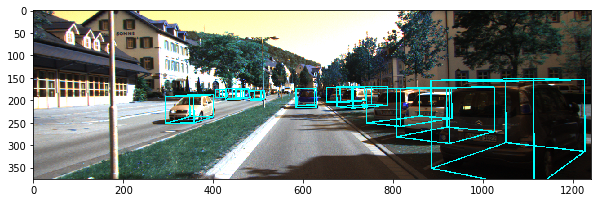

In [389]:
test1 = show_lidar_corners(test_image, lidar_corners, calib)
plt.imshow(test1)

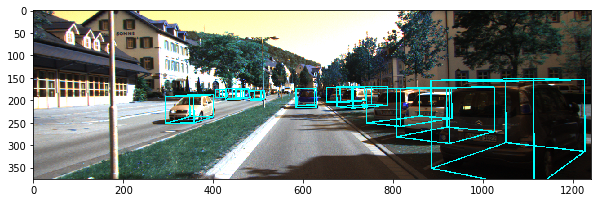

In [385]:
test1 = show_lidar_corners(test_image, new_lidar, calib)
plt.imshow(test1)

In [33]:

lidar_corners[1].reshape((3, 8)).astype(np.float32)

array([[  5.892e+00,   6.366e+00,   9.857e+00,   9.383e+00,   5.869e+00,
          6.343e+00,   9.834e+00,   9.360e+00],
       [  1.101e+00,   2.524e+00,   1.360e+00,  -6.296e-02,   1.099e+00,
          2.522e+00,   1.359e+00,  -6.410e-02],
       [ -1.562e+00,  -1.554e+00,  -1.503e+00,  -1.511e+00,   7.674e-03,
          1.573e-02,   6.656e-02,   5.851e-02]], dtype=float32)

In [33]:
def show_cam_corners(test_image, cam_corners, calib):
    test = np.copy(test_image)
    for i in range(cam_corners.shape[0]):
        if cam_corners[i].shape[0] == 24:
            cam_corners_i = cam_corners[i].reshape((3, 8))
        img_corners = projectToImage(cam_corners_i, calib['P2'])
        img = drawBox3D(test, img_corners)
    return img 


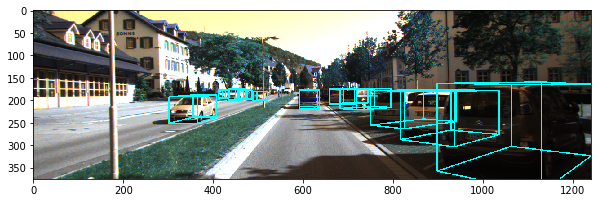

In [49]:
img = show_cam_corners(test_image, cam_corners, calib) 
plt.imshow(img)

#### test cnr to bv

In [50]:
TOP_X_MAX = 70.3
TOP_X_MIN = 0
TOP_Y_MIN = -40
TOP_Y_MAX = 40
RES = 0.1
LIDAR_HEIGHT = 1.73
CAR_HEIGHT = 1.56
X0, Xn = 0, int((TOP_X_MAX - TOP_X_MIN) // RES) + 1
Y0, Yn = 0, int((TOP_Y_MAX - TOP_Y_MIN) // RES) + 1

def _lidar_to_bv_coord(x, y):
    X0, Xn = 0, int((TOP_X_MAX - TOP_X_MIN) // RES) + 1
    Y0, Yn = 0, int((TOP_Y_MAX - TOP_Y_MIN) // RES) + 1

    xx = Yn - (y - TOP_Y_MIN) // RES
    yy = Xn - (x - TOP_X_MIN) // RES
    return xx, yy

def corners_to_bv_single(corners):
    pts_2D = np.zeros(4)
    # min & max in lidar coords
    xmin = np.min(corners[:8])
    xmax = np.max(corners[:8])
    ymin = np.min(corners[8:16])
    ymax = np.max(corners[8:16])

    # top left bottom right at lidar bird view coords
    pts_2D = np.array([xmax, ymax, xmin, ymin])
    
    pts_2D[0], pts_2D[1] = _lidar_to_bv_coord(pts_2D[0], pts_2D[1])
    pts_2D[2], pts_2D[3] = _lidar_to_bv_coord(pts_2D[2], pts_2D[3])

    return pts_2D

In [51]:
lidar_bv = kitti.roidb[38]['boxes_bv']
print lidar_bv

[[ 391.  402.  408.  439.]
 [ 424.  617.  464.  655.]
 [ 428.  582.  464.  616.]
 [ 425.  543.  466.  582.]
 [ 315.  175.  331.  215.]
 [ 327.  499.  342.  536.]
 [ 423.  436.  464.  475.]
 [ 419.  368.  459.  409.]
 [ 275.  161.  293.  207.]
 [ 276.   97.  292.  139.]
 [ 236.   90.  249.  120.]]


In [52]:
lidar_bv2 = corners_to_bv_single(lidar_corners[2])
print lidar_bv2

[ 428.  582.  464.  616.]


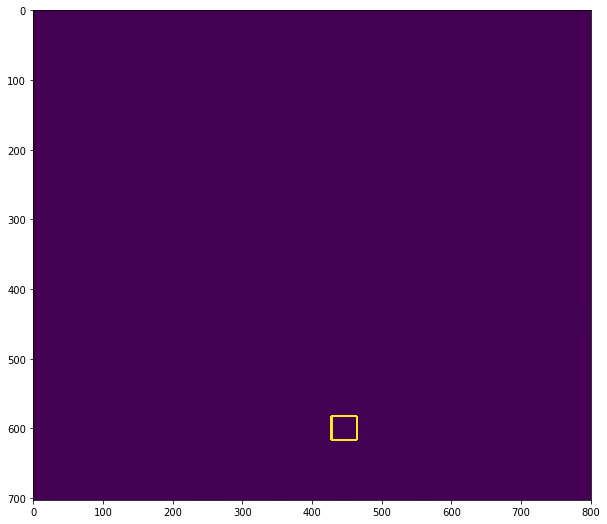

In [53]:
test = np.copy(test_lidar2)
num = len(lidar_bv2)
for n in range(1,2):
    x1,y1,x2,y2 = lidar_bv2
    cv2.rectangle(test,(x1,y1), (x2,y2), (255,255,255), 2)
plt.imshow(test)

In [54]:
def show_lidar_bv(test_image, lidar_bv):
    test = np.copy(test_image)
    num = len(lidar_bv)
    for n in range(num):
        x1,y1,x2,y2 = lidar_bv[n]
        cv2.rectangle(test,(x1,y1), (x2,y2), (255,255,0), 2)
    return test

In [576]:
rys = kitti.roidb[8]['ry']
print rys

[-1.29  1.9  -1.31 -1.25  1.95 -1.25]


In [591]:
ry = rys[1]
R = np.array([[np.cos(ry), -np.sin(ry)],
                [np.sin(ry), np.cos(ry)]])

In [594]:
lidar_bv[1]

array([ 401.,  645.,  375.,  605.], dtype=float32)

In [595]:
bv = np.dot(R, lidar_bv[1].reshape((2,2)))
print bv.reshape(4)

[-484.502 -781.033  258.233  414.773]


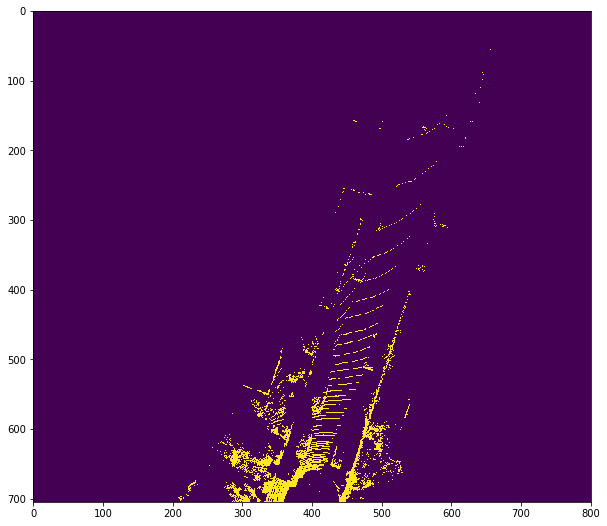

In [602]:
test = np.copy(test_lidar2)
num = len(lidar_bv2)
for n in range(1,2):
    ry = rys[n]
    R = np.array([[np.cos(ry+np.pi/2), -np.sin(ry+np.pi/2)],
            [np.sin(ry+np.pi/2), np.cos(ry+np.pi/2)]])
    bv = np.dot(R, lidar_bv2[n].reshape((2,2)))
    x1,y1,x2,y2 = bv.reshape(4).astype(np.int32)
    cv2.rectangle(test,(x1,y1), (x2,y2), (255,255,255), 2)
plt.imshow(test)

#### Test corners to lidar boxes3D

In [55]:
def lidar_cnr_to_3d_single(corners, lwh):
    """
    lidar_corners to Boxex3D single 
    """
    boxes_3d = np.zeros(6)
    corners = corners.reshape((3, 8))
    boxes_3d[:3] = corners.mean(1)
    boxes_3d[3:] = lwh
    return boxes_3d

In [56]:
def lidar_cnr_to_3d(corners, lwh):
    """
    lidar_corners to lidar Boxex3D
    """
    boxes_3d = np.zeros((corners.shape[0], 6))
    corners = corners.reshape((3, 8))
    boxes_3d[:, 0] = corners.mean(1)
    boxes_3d[:, 3:] = lwh
    return boxes_3d

In [57]:
def cam_to_lidar_3d_single(pts_3D, P):
    """
    convert camera(x, y, z, l, w, h) to lidar (x, y, z, l, w, h)
    """

    points = pts_3D[:3]
    points = np.vstack((points, 0)).reshape((4, 1))

    R = np.linalg.inv(P[:, :3])
    T = np.zeros((3, 1))
    T[0] = -P[1,3] 
    T[1] = -P[2,3]
    T[2] = P[0,3]
    RT = np.hstack((R, T))

    points_lidar = np.dot(RT, points)

    pts_3D_lidar = np.zeros(6)
    pts_3D_lidar[:3] = points_lidar.flatten()

    pts_3D_lidar[3:6] = pts_3D[3:6]

    return pts_3D_lidar

In [58]:
def cam_to_lidar_3d(pts_3D, P):
    """
    convert camera(x, y, z, l, w, h) to lidar (x, y, z, l, w, h)
    """

    points = pts_3D[:,:3].transpose()
    points = np.vstack((points, np.zeros(pts_3D.shape[0])))

    R = np.linalg.inv(P[:, :3])
    T = np.zeros((3, 1))
    T[0] = -P[1,3] 
    T[1] = -P[2,3]
    T[2] = P[0,3]
    RT = np.hstack((R, T))

    points_lidar = np.dot(RT, points)
    pts_3D_lidar = np.zeros((pts_3D.shape))
    pts_3D_lidar[:,:3] = points_lidar.transpose()
    pts_3D_lidar[:,3:6] = pts_3D[:,3:6]

    return pts_3D_lidar

In [65]:
boxes = kitti.roidb[38]['boxes_3D_cam']
print boxes

[[  0.12         1.72000003  28.28000069   3.69000006   1.64999998
    1.55999994]
 [  4.38000011   1.53999996   6.69000006   3.96000004   1.61000001   1.63      ]
 [  4.61000013   1.57000005  10.39999962   3.3599999    1.63         1.49000001]
 [  4.63000011   1.51999998  14.02000046   4.09000015   1.60000002
    1.40999997]
 [ -7.38000011   1.91999996  50.90000153   3.92000008   1.63999999   1.37      ]
 [ -6.48999977   1.83000004  18.65999985   3.61999989   1.47000003   1.38      ]
 [  4.46999979   1.52999997  24.75         4.09000015   1.59000003
    1.49000001]
 [  4.05999994   1.5         31.45999908   4.05000019   1.63         1.39999998]
 [-11.26000023   1.88        52.04000092   4.48999977   1.67999995
    1.66999996]
 [-11.21000004   1.98000002  58.61000061   4.19999981   1.58000004   1.63      ]
 [-15.36999989   1.87        59.95999908   2.95000005   1.28999996
    1.47000003]]


In [66]:
boxes[:,:3].transpose()

array([[  0.12      ,   4.38000011,   4.61000013,   4.63000011,
         -7.38000011,  -6.48999977,   4.46999979,   4.05999994,
        -11.26000023, -11.21000004, -15.36999989],
       [  1.72000003,   1.53999996,   1.57000005,   1.51999998,
          1.91999996,   1.83000004,   1.52999997,   1.5       ,
          1.88      ,   1.98000002,   1.87      ],
       [ 28.28000069,   6.69000006,  10.39999962,  14.02000046,
         50.90000153,  18.65999985,  24.75      ,  31.45999908,
         52.04000092,  58.61000061,  59.95999908]], dtype=float32)

In [67]:
boxes_lidar = cam_to_lidar_3d(boxes, calib['Tr_velo2cam'])
print boxes_lidar

[[ 28.30246281   0.09402851  -1.30112749   3.69000006   1.64999998
    1.55999994]
 [  6.74487057  -4.32841967  -1.44346898   3.96000004   1.61000001   1.63      ]
 [ 10.45653505  -4.53047802  -1.41867159   3.3599999    1.63         1.49000001]
 [ 14.07544693  -4.52327771  -1.31508599   4.09000015   1.60000002
    1.40999997]
 [ 50.86579984   7.76414826  -1.1615341    3.92000008   1.63999999   1.37      ]
 [ 18.6356196    6.63154078  -1.54948835   3.61999989   1.47000003   1.38      ]
 [ 24.80290852  -4.2825444   -1.1661012    4.09000015   1.59000003
    1.49000001]
 [ 31.50844882  -3.82209348  -1.03649305   4.05000019   1.63         1.39999998]
 [ 51.9758189   11.65258559  -1.10226551   4.48999977   1.67999995
    1.66999996]
 [ 58.54676897  11.65209093  -1.10499977   4.19999981   1.58000004   1.63      ]
 [ 59.86361251  15.82204903  -0.9724566    2.95000005   1.28999996
    1.47000003]]


In [68]:
def lidar_to_cam_3d(pts_3D, Tr):
    
    points = pts_3D[:,:3].transpose()
    points = np.vstack((points, np.zeros(pts_3D.shape[0])))

    RT = Tr
    points_cam = np.dot(RT, points)
    pts_3D_cam = np.zeros((pts_3D.shape))
    pts_3D_cam[:,:3] = points_cam.transpose()
    pts_3D_cam[:,3:6] = pts_3D[:,3:6]
    return pts_3D_cam

In [69]:
boxes_3d_lidar = kitti.roidb[38]['boxes_3D']
print boxes_3d_lidar

[[ 28.29091644   0.09346062  -0.52121317   3.69000006   1.64999998
    1.55999994]
 [  6.73280621  -4.32901287  -0.62855852   3.96000004   1.61000001   1.63      ]
 [ 10.44550705  -4.53102016  -0.67375344   3.3599999    1.63         1.49000001]
 [ 14.06501102  -4.52379084  -0.61016345   4.09000015   1.60000002
    1.40999997]
 [ 50.85565948   7.76364946  -0.47660935   3.92000008   1.63999999   1.37      ]
 [ 18.62540627   6.63103867  -0.85956413   3.61999989   1.47000003   1.38      ]
 [ 24.79188156  -4.28308678  -0.42118305   4.09000015   1.59000003
    1.49000001]
 [ 31.49808693  -3.82260299  -0.33656996   4.05000019   1.63         1.39999998]
 [ 51.96345901  11.65197754  -0.26735729   4.48999977   1.67999995
    1.66999996]
 [ 58.53470612  11.65149689  -0.29008931   4.19999981   1.58000004   1.63      ]
 [ 59.85273361  15.82151413  -0.23753732   2.95000005   1.28999996
    1.47000003]]


In [70]:
boxes_inv = lidar_to_cam_3d(boxes_lidar, calib['Tr_velo2cam'])
print boxes_inv

[[  0.11999999   1.72000003  28.28000012   3.69000006   1.64999998
    1.55999994]
 [  4.38000001   1.53999998   6.68999993   3.96000004   1.61000001   1.63      ]
 [  4.61000003   1.57000007  10.39999941   3.3599999    1.63         1.49000001]
 [  4.63000001   1.51999999  14.02000018   4.09000015   1.60000002
    1.40999997]
 [ -7.37999996   1.91999995  50.90000051   3.92000008   1.63999999   1.37      ]
 [ -6.48999963   1.83000005  18.65999948   3.61999989   1.47000003   1.38      ]
 [  4.46999968   1.52999998  24.74999951   4.09000015   1.59000003
    1.49000001]
 [  4.05999984   1.5         31.45999846   4.05000019   1.63         1.39999998]
 [-11.25999999   1.87999999  52.03999988   4.48999977   1.67999995
    1.66999996]
 [-11.2099998    1.98000001  58.60999944   4.19999981   1.58000004   1.63      ]
 [-15.36999955   1.86999999  59.95999789   2.95000005   1.28999996
    1.47000003]]


In [71]:
def lidar_3d_to_bv(rois_3d):
    """
    cast lidar 3d points(x, y, z, l, w, h) to bird view (x1, y1, x2, y2)
    """

    rois = np.zeros((rois_3d.shape[0], 4))

    rois[:, 0] = rois_3d[:, 0] + rois_3d[:, 3] * 0.5
    rois[:, 1] = rois_3d[:, 1] + rois_3d[:, 4] * 0.5
    rois[:, 2] = rois_3d[:, 0] - rois_3d[:, 3] * 0.5
    rois[:, 3] = rois_3d[:, 1] - rois_3d[:, 4] * 0.5

    rois[:, 0], rois[:, 1] = _lidar_to_bv_coord(rois[:, 0], rois[:, 1])
    rois[:, 2], rois[:, 3] = _lidar_to_bv_coord(rois[:, 2], rois[:, 3])

    return rois.astype(np.float32)

In [72]:
lidar_bv2 = lidar_3d_to_bv(boxes_lidar)
print lidar_bv2

[[ 391.  402.  408.  439.]
 [ 436.  616.  452.  656.]
 [ 438.  582.  454.  616.]
 [ 438.  542.  454.  583.]
 [ 315.  175.  331.  214.]
 [ 327.  499.  342.  535.]
 [ 435.  435.  451.  476.]
 [ 431.  368.  447.  409.]
 [ 276.  161.  292.  206.]
 [ 276.   97.  292.  139.]
 [ 236.   90.  249.  120.]]


In [73]:
lidar_bv3 = lidar_3d_to_bv(boxes_3d_lidar)
print lidar_bv3

[[ 391.  402.  408.  439.]
 [ 436.  616.  452.  656.]
 [ 438.  582.  454.  616.]
 [ 438.  542.  454.  583.]
 [ 315.  175.  331.  215.]
 [ 327.  499.  342.  535.]
 [ 435.  435.  451.  476.]
 [ 431.  368.  447.  409.]
 [ 276.  161.  292.  206.]
 [ 276.   97.  292.  139.]
 [ 236.   90.  249.  120.]]


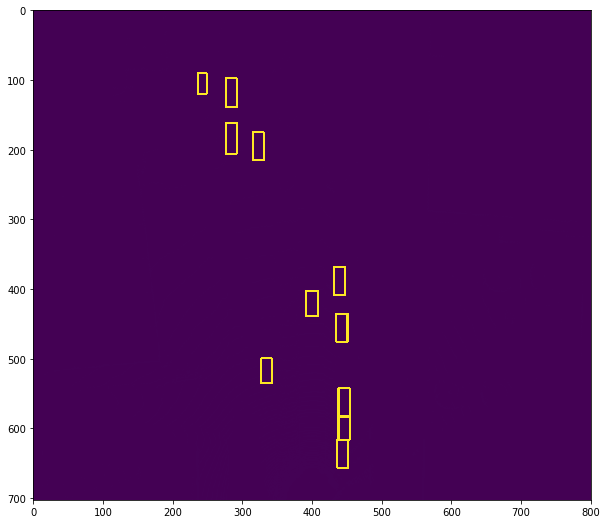

In [74]:
img = show_lidar_bv(test_lidar2, lidar_bv3)
plt.imshow(img)#, cmap='gray')

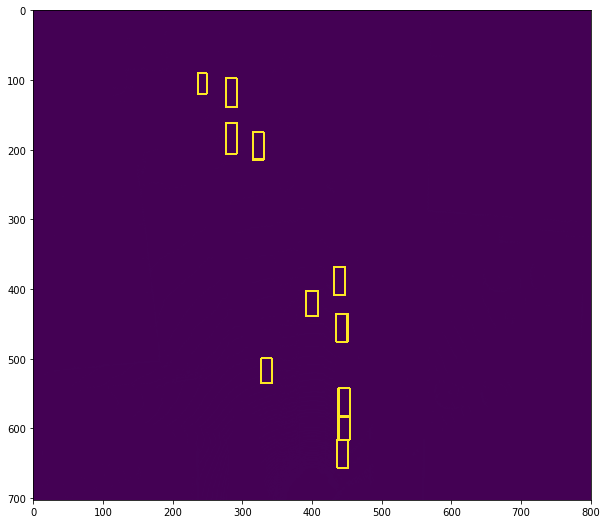

In [75]:
img = show_lidar_bv(test_lidar2, lidar_bv2)
plt.imshow(img)#, cmap='gray')

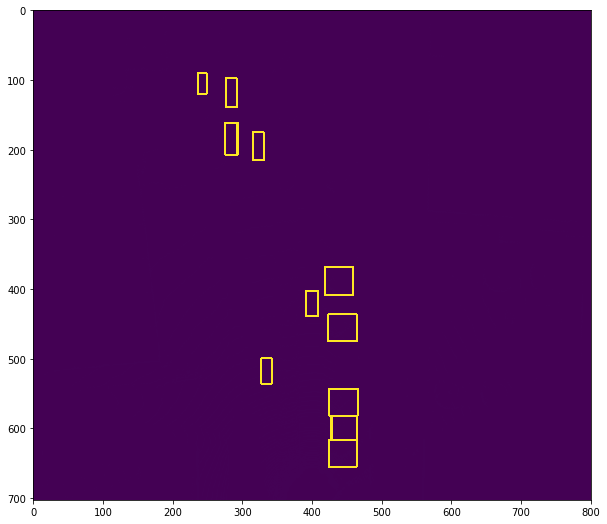

In [76]:
img = show_lidar_bv(test_lidar2, lidar_bv)
plt.imshow(img)#, cmap='gray')

#### Test lidar 3d boxes to image

In [77]:
boxes_lidar

array([[ 28.30246281,   0.09402851,  -1.30112749,   3.69000006,
          1.64999998,   1.55999994],
       [  6.74487057,  -4.32841967,  -1.44346898,   3.96000004,
          1.61000001,   1.63      ],
       [ 10.45653505,  -4.53047802,  -1.41867159,   3.3599999 ,
          1.63      ,   1.49000001],
       [ 14.07544693,  -4.52327771,  -1.31508599,   4.09000015,
          1.60000002,   1.40999997],
       [ 50.86579984,   7.76414826,  -1.1615341 ,   3.92000008,
          1.63999999,   1.37      ],
       [ 18.6356196 ,   6.63154078,  -1.54948835,   3.61999989,
          1.47000003,   1.38      ],
       [ 24.80290852,  -4.2825444 ,  -1.1661012 ,   4.09000015,
          1.59000003,   1.49000001],
       [ 31.50844882,  -3.82209348,  -1.03649305,   4.05000019,
          1.63      ,   1.39999998],
       [ 51.9758189 ,  11.65258559,  -1.10226551,   4.48999977,
          1.67999995,   1.66999996],
       [ 58.54676897,  11.65209093,  -1.10499977,   4.19999981,
          1.58000004,   1.6

In [78]:
def lidar_3d_to_corners(pts_3D):
    """ 
    convert pts_3D_lidar (x, y, z, l, w, h) to
    8 corners (x0, ... x7, y0, ...y7, z0, ... z7)
    """
    # print "pts_3D shape: ", pts_3D.shape
    l = pts_3D[:, 3]
    w = pts_3D[:, 4]
    h = pts_3D[:, 5]

    l = l.reshape(-1, 1)
    w = w.reshape(-1, 1)
    h = h.reshape(-1, 1)

    x_corners = np.hstack((l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2))
    y_corners = np.hstack((w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2))
    z_corners = np.hstack((h,h,h,h,np.zeros(h.shape),np.zeros(h.shape),np.zeros(h.shape),np.zeros(h.shape)))

    corners = np.hstack((x_corners, y_corners, z_corners))
    # print "x_corners shape: ", x_corners.shape
    # print "corners shape: ", corners.shape

    corners[:,0:8] = corners[:,0:8] + pts_3D[:,0].reshape((-1, 1)).repeat(8, axis=1)
    corners[:,8:16] = corners[:,8:16] + pts_3D[:,1].reshape((-1, 1)).repeat(8, axis=1)
    corners[:,16:24] = corners[:,16:24] + pts_3D[:,2].reshape((-1, 1)).repeat(8, axis=1)

    return corners

In [79]:
corners_lidar = lidar_3d_to_corners(boxes_lidar)
print corners_lidar

[[ 30.14746283  30.14746283  26.45746278  26.45746278  30.14746283
   30.14746283  26.45746278  26.45746278   0.9190285   -0.73097147
   -0.73097147   0.9190285    0.9190285   -0.73097147  -0.73097147
    0.9190285    0.25887245   0.25887245   0.25887245   0.25887245
   -1.30112749  -1.30112749  -1.30112749  -1.30112749]
 [  8.72487059   8.72487059   4.76487055   4.76487055   8.72487059
    8.72487059   4.76487055   4.76487055  -3.52341966  -5.13341968
   -5.13341968  -3.52341966  -3.52341966  -5.13341968  -5.13341968
   -3.52341966   0.18653101   0.18653101   0.18653101   0.18653101
   -1.44346898  -1.44346898  -1.44346898  -1.44346898]
 [ 12.136535    12.136535     8.7765351    8.7765351   12.136535    12.136535
    8.7765351    8.7765351   -3.71547802  -5.34547802  -5.34547802
   -3.71547802  -3.71547802  -5.34547802  -5.34547802  -3.71547802
    0.07132842   0.07132842   0.07132842   0.07132842  -1.41867159
   -1.41867159  -1.41867159  -1.41867159]
 [ 16.12044701  16.12044701  12.0

In [352]:
corners_lidar.shape

(11, 24)

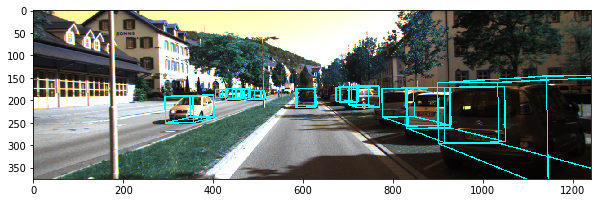

In [366]:
test1 = show_lidar_corners(test_image, corners_lidar, calib)
plt.imshow(test1)

In [81]:
def lidar_3d_to_cam(pts_3D, Tr):
    """
    convert lidar(x, y, z, l, w, h) to cam (x, y, z, l, w, h)
    """

    points = pts_3D[:,:3].transpose()
    points = np.vstack((points, np.zeros(pts_3D.shape[0])))

    RT = Tr

    points_cam = np.dot(RT, points)
    pts_3D_cam = np.zeros((pts_3D.shape))
    pts_3D_cam[:,:3] = points_cam.transpose()
    pts_3D_cam[:,3:6] = pts_3D[:,3:6]

    return pts_3D_cam

In [82]:
boxes_inv = lidar_3d_to_cam(boxes_lidar, calib['Tr_velo2cam'])
print boxes_inv

[[  0.11999999   1.72000003  28.28000012   3.69000006   1.64999998
    1.55999994]
 [  4.38000001   1.53999998   6.68999993   3.96000004   1.61000001   1.63      ]
 [  4.61000003   1.57000007  10.39999941   3.3599999    1.63         1.49000001]
 [  4.63000001   1.51999999  14.02000018   4.09000015   1.60000002
    1.40999997]
 [ -7.37999996   1.91999995  50.90000051   3.92000008   1.63999999   1.37      ]
 [ -6.48999963   1.83000005  18.65999948   3.61999989   1.47000003   1.38      ]
 [  4.46999968   1.52999998  24.74999951   4.09000015   1.59000003
    1.49000001]
 [  4.05999984   1.5         31.45999846   4.05000019   1.63         1.39999998]
 [-11.25999999   1.87999999  52.03999988   4.48999977   1.67999995
    1.66999996]
 [-11.2099998    1.98000001  58.60999944   4.19999981   1.58000004   1.63      ]
 [-15.36999955   1.86999999  59.95999789   2.95000005   1.28999996
    1.47000003]]


In [83]:
corners_lidar.shape

(11, 24)

In [84]:
def corners_to_img(corners, Tr, R0, P2):
    
    Tr = Tr.reshape((3, 4))
    R0 = R0.reshape((3, 3))
    P2 = P2.reshape((3, 4))
    
    if 24 in corners.shape:
        corners = corners.reshape((3, 8))

    RO = np.vstack((R0, np.zeros(3)))
    corners = np.vstack((corners, np.zeros(8)))

    mat1 =  np.dot(P2, RO)
    mat2 = np.dot(mat1, Tr)
    img_cor = np.dot(mat2, corners)
    return img_cor

In [220]:
def lidar_cnr_to_img_single(corners, Tr, R0, P2):

    if 24 in corners.shape:
        corners = corners.reshape((3, 8))
        
    R0 = R0.reshape((4, 3))
    corners = np.vstack((corners, np.zeros(8)))

    mat1 =  np.dot(P2, R0)
    mat2 = np.dot(mat1, Tr)
    img_cor = np.dot(mat2, corners)
    print mat2
    print corners
    print img_cor
    return img_cor

In [371]:
# def lidar_cnr_to_img(corners, Tr, R0, P2):
    
#     img_boxes = np.zeros((corners.shape[0], 4))
    
#     R0 = R0.reshape((4, 3))
#     Tr = Tr.reshape((3, 4))
#     P2 = P2.reshape((3, 4))

#     for i in range(corners.shape[0]):
        
#         img_cor = lidar_cnr_to_img_single(corners[i], Tr, R0, P2)
# #         print img_cor
        
#         img_cor = img_cor / np.abs(img_cor[2])
#         print img_cor
        
#         xmin = np.min(img_cor[0])
#         xmax = np.max(img_cor[0])
#         ymin = np.min(img_cor[1])
#         ymax = np.max(img_cor[1])
        
# #         xmin = np.max((0, np.min(img_cor[0])))
# #         xmax = np.max((0, np.max(img_cor[0])))
# #         ymin = np.max((0, np.min(img_cor[1])))
# #         ymax = np.max((0, np.max(img_cor[1])))
 
#         img_boxes[i, :] = np.array([xmin, ymin, xmax, ymax])
        
#     return img_boxes.astype(np.int32)

In [390]:
def lidar_cnr_to_img(corners, Tr, R0, P2):
    
    img_boxes = np.zeros((corners.shape[0], 4))
    
    R0 = R0.reshape((4, 3))
    Tr = Tr.reshape((3, 4))
    P2 = P2.reshape((3, 4))
    
    new_corners = corners.reshape((-1, 3, 8))

    mat = reduce(np.dot, [P2, R0, Tr])
    
    new_corners = np.append(new_corners, np.zeros((new_corners.shape[0], 1, 8)), 1)

    img_cor = np.dot(mat, new_corners).transpose(1, 0, 2)
    
    xs = img_cor[:,0,:] / np.abs(img_cor[:,2,:])
    ys = img_cor[:,1,:] / np.abs(img_cor[:,2,:])
    
    xmin = np.min(xs, axis=1).reshape(-1, 1)
    xmax = np.max(xs, axis=1).reshape(-1, 1)
    ymin = np.min(ys, axis=1).reshape(-1, 1)
    ymax = np.max(ys, axis=1).reshape(-1, 1)

    img_boxes = np.hstack((xmin, ymin, xmax, ymax))
        
    return img_boxes.astype(np.int32)

In [343]:
np.dot(mat[:3,:], nmat).transpose(1, 0, 2)

array([[[ 30.147,  30.147,  26.457,  26.457,  30.147,  30.147,  26.457,
          26.457],
        [  0.919,  -0.731,  -0.731,   0.919,   0.919,  -0.731,  -0.731,
           0.919],
        [  0.259,   0.259,   0.259,   0.259,  -1.301,  -1.301,  -1.301,
          -1.301]],

       [[  8.725,   8.725,   4.765,   4.765,   8.725,   8.725,   4.765,
           4.765],
        [ -3.523,  -5.133,  -5.133,  -3.523,  -3.523,  -5.133,  -5.133,
          -3.523],
        [  0.187,   0.187,   0.187,   0.187,  -1.443,  -1.443,  -1.443,
          -1.443]],

       [[ 12.137,  12.137,   8.777,   8.777,  12.137,  12.137,   8.777,
           8.777],
        [ -3.715,  -5.345,  -5.345,  -3.715,  -3.715,  -5.345,  -5.345,
          -3.715],
        [  0.071,   0.071,   0.071,   0.071,  -1.419,  -1.419,  -1.419,
          -1.419]],

       [[ 16.12 ,  16.12 ,  12.03 ,  12.03 ,  16.12 ,  16.12 ,  12.03 ,
          12.03 ],
        [ -3.723,  -5.323,  -5.323,  -3.723,  -3.723,  -5.323,  -5.323,
          -3

In [360]:
nmat = mat[:3,:]

In [348]:
t1 = time.time()
for i in range(10000):
    img_cor = np.array(map(lambda x:np.dot(nmat, np.vstack((x,np.zeros(8)))), new_corners)) 
t2 = time.time()
print t2 - t1

0.553407907486


In [363]:
new_corners = corners_lidar.reshape((-1, 3, 8))

In [364]:
new_corners.shape

(11, 3, 8)

In [365]:
t1 = time.time()
for i in range(10000):
    new_corners_ = np.append(new_corners, np.zeros((new_corners.shape[0], 1, 8)), 1)
    img_cor = np.dot(nmat, new_corners_).transpose(1, 0, 2)
t2 = time.time()
print t2 - t1

0.0978169441223


In [232]:
calib2

array([[  7.215e+02,   0.000e+00,   6.096e+02,   4.486e+01,   0.000e+00,
          7.215e+02,   1.729e+02,   2.164e-01,   0.000e+00,   0.000e+00,
          1.000e+00,   2.746e-03],
       [  7.215e+02,   0.000e+00,   6.096e+02,  -3.395e+02,   0.000e+00,
          7.215e+02,   1.729e+02,   2.200e+00,   0.000e+00,   0.000e+00,
          1.000e+00,   2.730e-03],
       [  9.999e-01,   9.838e-03,  -7.445e-03,  -9.870e-03,   9.999e-01,
         -4.278e-03,   7.403e-03,   4.352e-03,   1.000e+00,   0.000e+00,
          0.000e+00,   1.000e+00],
       [  7.534e-03,  -1.000e+00,  -6.166e-04,  -4.070e-03,   1.480e-02,
          7.281e-04,  -9.999e-01,  -7.632e-02,   9.999e-01,   7.524e-03,
          1.481e-02,  -2.718e-01]])

In [233]:
img_boxes = lidar_cnr_to_img(test_cnr, calib['Tr_velo2cam'], calib2[2], calib['P2'])
print img_boxes

[[ 1.     0.01  -0.007]
 [-0.01   1.    -0.004]
 [ 0.007  0.004  1.   ]
 [ 0.     0.     1.   ]]
[[  6.545e+02  -7.211e+02  -5.870e-01  -1.801e+02]
 [  1.806e+02   7.646e+00  -7.196e+02  -1.013e+02]
 [  1.003e+00   1.450e-04   1.049e-02  -2.729e-01]]
[[  6.366   6.366   2.433   2.433   6.366   6.366   2.433   2.433]
 [ 41.035  39.404  39.404  41.035  41.035  39.404  39.404  41.035]
 [  0.783   0.783   0.783   0.783  -0.74   -0.74   -0.74   -0.74 ]
 [  0.      0.      0.      0.      0.      0.      0.      0.   ]]
[[ -2.542e+04  -2.425e+04  -2.682e+04  -2.800e+04  -2.542e+04  -2.425e+04
   -2.682e+04  -2.800e+04]
 [  9.003e+02   8.878e+02   1.774e+02   1.899e+02   1.996e+03   1.984e+03
    1.273e+03   1.286e+03]
 [  6.397e+00   6.397e+00   2.453e+00   2.454e+00   6.381e+00   6.381e+00
    2.437e+00   2.438e+00]]
[[ -3.974e+03  -3.790e+03  -1.093e+04  -1.141e+04  -3.984e+03  -3.800e+03
   -1.100e+04  -1.149e+04]
 [  1.407e+02   1.388e+02   7.233e+01   7.740e+01   3.128e+02   3.108e+02
 

In [243]:
boxes

array([[  592.08,   176.5 ,   637.55,   219.52],
       [  895.35,   158.55,  1241.  ,   374.  ],
       [  817.68,   176.9 ,  1038.04,   302.31],
       [  749.97,   177.62,   940.82,   262.93],
       [  489.07,   180.53,   521.27,   201.03],
       [  302.47,   188.9 ,   409.18,   250.55],
       [  682.53,   173.56,   796.81,   220.86],
       [  659.69,   174.94,   745.56,   209.34],
       [  434.34,   175.49,   472.4 ,   199.91],
       [  456.14,   177.  ,   487.16,   197.96],
       [  412.71,   177.61,   437.08,   195.86]], dtype=float32)

In [253]:
inds = np.where((600 <= boxes[:,2]) &  (boxes[:,2] <= 1000) & ( 200 <= boxes[:, 3]))
print inds
print boxes[inds]

(array([0, 3, 6, 7]),)
[[ 592.08  176.5   637.55  219.52]
 [ 749.97  177.62  940.82  262.93]
 [ 682.53  173.56  796.81  220.86]
 [ 659.69  174.94  745.56  209.34]]


In [238]:
def _filter_img_boxes(boxes, im_info):
    """Remove all boxes with any side smaller than min_size."""
    padding = 100
    w_min = -padding
    w_max = im_info[1] + padding
    h_min = -padding
    h_max = im_info[0] + padding
#     keep = np.where((w_min <= boxes[:,2] <= w_max) & ( h_min <= boxes[:,3] <= h_max))[0]
    keep = np.where((w_min <= boxes[:,0]) & (boxes[:,2] <= w_max) & (h_min <= boxes[:,1]) & (boxes[:,3] <= h_max))[0]
    return keep


In [239]:
_filter_boxes(boxes, [375, 1242])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [225]:
x1,y1,x2,y2 = img_boxes[n]
cv2.rectangle(test,(x1,y1), (x2,y2), (255,255,0), 2)

IndexError: index 1 is out of bounds for axis 0 with size 1

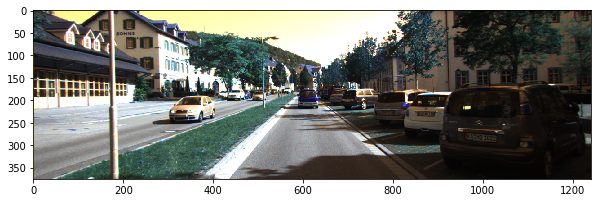

In [226]:
img = show_image_boxes(test_image, img_boxes)
plt.imshow(img)

In [305]:
img_boxes = lidar_cnr_to_img(corners_lidar, calib['Tr_velo2cam'], calib2[2], calib['P2'])
print img_boxes

[[ 1.     0.01  -0.007]
 [-0.01   1.    -0.004]
 [ 0.007  0.004  1.   ]
 [ 0.     0.     1.   ]]
[[  6.545e+02  -7.211e+02  -5.870e-01  -1.801e+02]
 [  1.806e+02   7.646e+00  -7.196e+02  -1.013e+02]
 [  1.003e+00   1.450e-04   1.049e-02  -2.729e-01]]
[[ 30.147  30.147  26.457  26.457  30.147  30.147  26.457  26.457]
 [  0.919  -0.731  -0.731   0.919   0.919  -0.731  -0.731   0.919]
 [  0.259   0.259   0.259   0.259  -1.301  -1.301  -1.301  -1.301]
 [  0.      0.      0.      0.      0.      0.      0.      0.   ]]
[[ 19070.068  20259.857  17844.58   16654.791  19070.984  20260.772
   17845.496  16655.707]
 [  5265.379   5252.762   4586.346   4598.963   6388.03    6375.413
    5708.997   5721.614]
 [    30.231     30.231     26.531     26.532     30.215     30.215
      26.515     26.515]]
[[ 630.803  670.164  672.587  627.736  631.175  670.557  673.037  628.158]
 [ 174.169  173.753  172.866  173.34   211.419  211.003  215.313  215.787]
 [   1.       1.       1.       1.       1.       

In [306]:
def show_image_boxes(test_image, img_boxes):
    test = np.copy(test_image)
    num = len(img_boxes)
    for n in range(num):
        x1,y1,x2,y2 = img_boxes[n]
        cv2.rectangle(test,(x1,y1), (x2,y2), (255,255,0), 2)
    return test

In [395]:
corners_lidar

array([[ 30.147,  30.147,  26.457,  26.457,  30.147,  30.147,  26.457,
         26.457,   0.919,  -0.731,  -0.731,   0.919,   0.919,  -0.731,
         -0.731,   0.919,   0.259,   0.259,   0.259,   0.259,  -1.301,
         -1.301,  -1.301,  -1.301],
       [  8.725,   8.725,   4.765,   4.765,   8.725,   8.725,   4.765,
          4.765,  -3.523,  -5.133,  -5.133,  -3.523,  -3.523,  -5.133,
         -5.133,  -3.523,   0.187,   0.187,   0.187,   0.187,  -1.443,
         -1.443,  -1.443,  -1.443],
       [ 12.137,  12.137,   8.777,   8.777,  12.137,  12.137,   8.777,
          8.777,  -3.715,  -5.345,  -5.345,  -3.715,  -3.715,  -5.345,
         -5.345,  -3.715,   0.071,   0.071,   0.071,   0.071,  -1.419,
         -1.419,  -1.419,  -1.419],
       [ 16.12 ,  16.12 ,  12.03 ,  12.03 ,  16.12 ,  16.12 ,  12.03 ,
         12.03 ,  -3.723,  -5.323,  -5.323,  -3.723,  -3.723,  -5.323,
         -5.323,  -3.723,   0.095,   0.095,   0.095,   0.095,  -1.315,
         -1.315,  -1.315,  -1.315],
    

In [393]:
img_boxes = lidar_cnr_to_img(corners_lidar, calib2[3], calib2[2], calib2[0])
print img_boxes

[[ 627  172  673  215]
 [ 943  143 1432  393]
 [ 872  169 1092  293]
 [ 818  171  972  256]
 [ 526  178  558  198]
 [ 337  188  445  249]
 [ 746  168  813  215]
 [ 717  170  766  204]
 [ 472  173  509  197]
 [ 494  174  524  195]
 [ 449  175  474  194]]


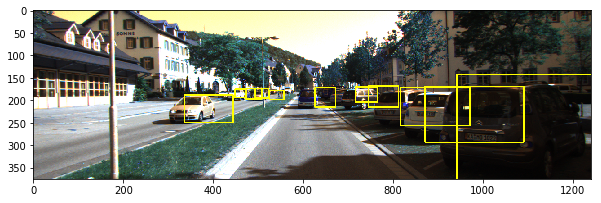

In [394]:
img = show_image_boxes(test_image, img_boxes)
plt.imshow(img)

In [236]:
boxes =  kitti.roidb[38]['boxes']

In [391]:
corners_lidar.shape

(11, 24)

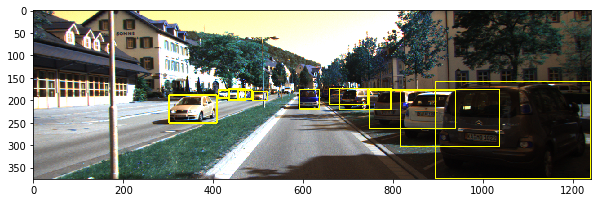

In [154]:
img = show_image_boxes(test_image, boxes)
plt.imshow(img)

In [116]:
lidar_bv2

array([[ 365.,  651.,  381.,  683.],
       [ 381.,  606.,  396.,  643.],
       [ 431.,  626.,  445.,  657.],
       [ 402.,  541.,  418.,  577.],
       [ 462.,  350.,  479.,  391.],
       [ 476.,  491.,  492.,  515.]], dtype=float32)

In [117]:
TOP_X_MAX = 70.3
TOP_X_MIN = 0
TOP_Y_MIN = -40
TOP_Y_MAX = 40
RES = 0.1
LIDAR_HEIGHT = 1.73
CAR_HEIGHT = 1.56
X0, Xn = 0, int((TOP_X_MAX - TOP_X_MIN) // RES) + 1
Y0, Yn = 0, int((TOP_Y_MAX - TOP_Y_MIN) // RES) + 1

In [163]:
def bv_anchor_to_lidar(anchors):
    """
    convert 2d anchors to 3d anchors
    """
    ex_lengths = np.abs(anchors[:, 3] - anchors[:, 1]) 
    ex_widths = np.abs(anchors[:, 2] - anchors[:, 0]) 
#     ex_ctr_x = anchors[:, 0] + 0.5 * ex_widths
#     ex_ctr_y = anchors[:, 1] + 0.5 * ex_lengths
    ex_ctr_x = (anchors[:,0] + anchors[:,2]) / 2
    ex_ctr_y = (anchors[:,1] + anchors[:,3]) / 2

    ex_lengths = ex_lengths.reshape((anchors.shape[0], 1)) * RES
    ex_widths = ex_widths.reshape((anchors.shape[0], 1)) * RES
    ex_ctr_x = ex_ctr_x.reshape((anchors.shape[0], 1))
    ex_ctr_y = ex_ctr_y.reshape((anchors.shape[0], 1))
    
    ex_ctr_x, ex_ctr_y = _bv_to_lidar_coords(ex_ctr_x, ex_ctr_y)
    
    # TODO : figure out why
#     ex_ctr_x -= 10
#     ex_ctr_y += 10

    ex_heights = np.ones((anchors.shape[0], 1), dtype=np.float32) * CAR_HEIGHT
    ex_ctr_z = np.ones((anchors.shape[0], 1), dtype=np.float32) * -(LIDAR_HEIGHT-CAR_HEIGHT/2) # 

    anchors_3d = np.hstack((ex_ctr_x, ex_ctr_y, ex_ctr_z, ex_lengths, ex_widths, ex_heights))

    return anchors_3d

In [123]:
def _bv_to_lidar_coords(xx,yy):
    X0, Xn = 0, int((TOP_X_MAX-TOP_X_MIN)//RES)+1
    Y0, Yn = 0, int((TOP_Y_MAX-TOP_Y_MIN)//RES)+1
    y = Xn*RES-(xx+0.5)*RES + TOP_Y_MIN
    x = Yn*RES-(yy+0.5)*RES + TOP_X_MIN

    return x,y

In [ ]:
def bv_box_to_cnr(boxes):

    num=len(boxes)
    boxes3d = np.zeros((num,8,3),dtype=np.float32)
    for n in range(num):
        x1,y1,x2,y2 = boxes[n]
        points = [ (x1,y1), (x1,y2), (x2,y2), (x2,y1) ]
        for k in range(4):
            xx,yy = points[k]
            x,y  = top_to_lidar_coords(xx,yy)
            boxes3d[n,k,  :] = x,y, -2  ## <todo>
            boxes3d[n,4+k,:] = x,y,0.4

    return boxes3d

In [124]:
anchors_3d = bv_anchor_to_lidar(lidar_bv2)
print anchors_3d

[[  3.25   2.95  -0.95   3.2    1.6    1.56]
 [  7.5    1.4   -0.95   3.7    1.5    1.56]
 [  5.8   -3.55  -0.95   3.1    1.4    1.56]
 [ 14.05  -0.75  -0.95   3.6    1.6    1.56]
 [ 32.9   -6.8   -0.95   4.1    1.7    1.56]
 [ 19.65  -8.15  -0.95   2.4    1.6    1.56]]


In [125]:
boxes_cor = kitti.roidb[8]['boxes_3D']
print boxes_cor

[[  3.673   2.728  -0.884   3.23    1.57    1.6  ]
 [  7.863   1.23   -0.748   3.68    1.5     1.57 ]
 [  6.192  -3.763  -0.856   3.08    1.44    1.39 ]
 [ 14.458  -0.961  -0.602   3.66    1.6     1.47 ]
 [ 33.26   -6.989  -0.213   4.08    1.63    1.7  ]
 [ 20.035  -8.329  -0.665   2.47    1.59    1.59 ]]


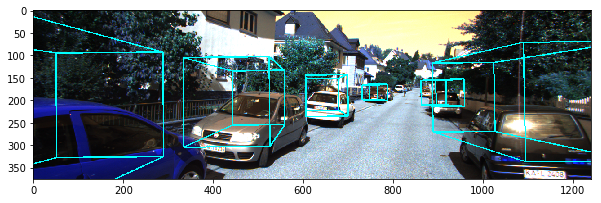

In [127]:
an_corners = lidar_3d_to_corners(anchors_3d)
test1 = show_lidar_corners(test_image, an_corners, calib)
plt.imshow(test1)

In [680]:
boxes_cor = kitti.roidb[8]['boxes_corners']
print boxes_cor

[[  5.452e+00   5.028e+00   1.918e+00   2.342e+00   5.428e+00   5.004e+00
    1.894e+00   2.318e+00   3.049e+00   1.537e+00   2.409e+00   3.921e+00
    3.048e+00   1.536e+00   2.408e+00   3.919e+00  -1.657e+00  -1.665e+00
   -1.710e+00  -1.703e+00  -5.744e-02  -6.481e-02  -1.102e-01  -1.028e-01]
 [  5.892e+00   6.366e+00   9.857e+00   9.383e+00   5.869e+00   6.343e+00
    9.834e+00   9.360e+00   1.101e+00   2.524e+00   1.360e+00  -6.296e-02
    1.099e+00   2.522e+00   1.359e+00  -6.410e-02  -1.562e+00  -1.554e+00
   -1.503e+00  -1.511e+00   7.674e-03   1.573e-02   6.656e-02   5.851e-02]
 [  7.873e+00   7.512e+00   4.531e+00   4.892e+00   7.853e+00   7.492e+00
    4.510e+00   4.871e+00  -3.451e+00  -4.845e+00  -4.074e+00  -2.680e+00
   -3.452e+00  -4.846e+00  -4.075e+00  -2.681e+00  -1.526e+00  -1.532e+00
   -1.576e+00  -1.570e+00  -1.363e-01  -1.426e-01  -1.862e-01  -1.799e-01]
 [  1.646e+01   1.596e+01   1.248e+01   1.297e+01   1.643e+01   1.594e+01
    1.246e+01   1.295e+01  -7.631e-

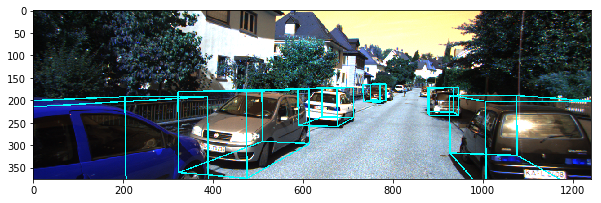

In [681]:
test1 = show_lidar_corners(test_image, boxes_cor, calib)
plt.imshow(test1)

## Test Proposal layer

In [132]:
from fast_rcnn.nms_wrapper import nms
from fast_rcnn.bbox_transform import clip_boxes
from utils.cython_bbox import bbox_overlaps
from rpn_msr.generate_anchors import generate_anchors_bv, generate_anchors

In [133]:
generate_anchors()

array([[ -84.,  -40.,   99.,   55.],
       [-176.,  -88.,  191.,  103.],
       [-360., -184.,  375.,  199.],
       [ -56.,  -56.,   71.,   71.],
       [-120., -120.,  135.,  135.],
       [-248., -248.,  263.,  263.],
       [ -36.,  -80.,   51.,   95.],
       [ -80., -168.,   95.,  183.],
       [-168., -344.,  183.,  359.]])

In [134]:
def _filter_boxes(boxes, min_size):
    """Remove all boxes with any side smaller than min_size."""
    ws = boxes[:, 2] - boxes[:, 0] + 1
    hs = boxes[:, 3] - boxes[:, 1] + 1
    keep = np.where((ws >= min_size) & (hs >= min_size))[0]
    return keep

In [187]:
_anchors = generate_anchors_bv()
# _anchors = generate_anchors(scales=np.array([0.5, 1, 2]))
_num_anchors = _anchors.shape[0]

_feat_stride = 4

im_info = [800, 703]

height, width = 176, 200

# Enumerate all shifts
shift_x = np.arange(0, width) * _feat_stride
shift_y = np.arange(0, height) * _feat_stride
shift_x, shift_y = np.meshgrid(shift_x, shift_y)
shifts = np.vstack((shift_x.ravel(), shift_y.ravel(),
                    shift_x.ravel(), shift_y.ravel())).transpose()

A = _num_anchors
K = shifts.shape[0]
anchors = _anchors.reshape((1, A, 4)) + \
          shifts.reshape((1, K, 4)).transpose((1, 0, 2))
anchors = anchors.reshape((K * A, 4))

proposals_bv = clip_boxes(anchors, im_info[:2])

keep = _filter_boxes(proposals_bv, 5)

batch_inds = np.zeros((proposals_bv.shape[0], 1), dtype=np.float32)
blob_bv = np.hstack((batch_inds, proposals_bv.astype(np.float32, copy=False)))




In [188]:
blob_bv.shape

(140800, 5)

In [201]:
idx = np.random.randint(blob_bv.shape[0], size=2000)
sample_bv = blob_bv[idx, :]
print sample_bv.shape

(2000, 5)


In [202]:
sample_bv

array([[   0.,   60.,  201.,   76.,  240.],
       [   0.,   89.,  428.,  128.,  444.],
       [   0.,  432.,    1.,  448.,   40.],
       ..., 
       [   0.,  266.,  615.,  271.,  625.],
       [   0.,  185.,  104.,  224.,  120.],
       [   0.,  702.,    0.,  702.,    8.]], dtype=float32)

In [203]:
np.ascontiguousarray(lidar_bv[:, :4], dtype=np.float)

array([[ 361.,  649.,  385.,  685.],
       [ 375.,  605.,  401.,  645.],
       [ 427.,  625.,  449.,  658.],
       [ 397.,  539.,  423.,  579.],
       [ 455.,  349.,  485.,  393.],
       [ 472.,  489.,  495.,  517.]])

In [204]:
np.ascontiguousarray(sample_bv[:, 1:5], dtype=np.float)

array([[  60.,  201.,   76.,  240.],
       [  89.,  428.,  128.,  444.],
       [ 432.,    1.,  448.,   40.],
       ..., 
       [ 266.,  615.,  271.,  625.],
       [ 185.,  104.,  224.,  120.],
       [ 702.,    0.,  702.,    8.]])

In [205]:
def bbox_overlaps(boxes, query_boxes):
    N = boxes.shape[0]
    K = query_boxes.shape[0]

    overlaps = np.zeros((N, K), dtype=np.float)
    for k in range(K):
        box_area = (
            (query_boxes[k, 2] - query_boxes[k, 0] + 1) *
            (query_boxes[k, 3] - query_boxes[k, 1] + 1)
        )
        
        for n in range(N):
            iw = (
                max(boxes[n, 2], query_boxes[k, 2]) -
                min(boxes[n, 0], query_boxes[k, 0]) + 1
            )
            
            if iw > 0:
                ih = (
                    max(boxes[n, 3], query_boxes[k, 3]) -
                    min(boxes[n, 1], query_boxes[k, 1]) + 1
                )
                if ih > 0:
                    ua = float(
                        (boxes[n, 2] - boxes[n, 0] + 1) *
                        (boxes[n, 3] - boxes[n, 1] + 1) +
                        box_area - iw * ih
                    )
                    overlaps[n, k] = iw * ih / ua
#                     print iw
    return overlaps

In [206]:
overlaps = bbox_overlaps(
    np.ascontiguousarray(sample_bv[:, 1:5], dtype=np.float),
    np.ascontiguousarray(lidar_bv[:, :4], dtype=np.float))

In [207]:
max_overlaps = overlaps.max(axis=1)
print max_overlaps[np.where(max_overlaps>0)]

[  2.114e+01   4.050e+01   2.221e+01   5.498e+00   2.114e+01   4.673e+00
   9.425e+01   1.628e+00   2.074e+03   1.948e+00   1.677e+01   6.519e+01
   2.114e+01   1.677e+01   2.114e+01   2.114e+01   1.677e+01]


In [208]:
DEBUG = True
gt_assignment = overlaps.argmax(axis=1)
max_overlaps = overlaps.max(axis=1)
# labels = lidar_bv[gt_assignment, 4]
if DEBUG:
    print "overlaps: ", overlaps
    print "gt assignment: ",  gt_assignment
    print "max_overlaps: ", max_overlaps
    print lidar_bv
#     print "labels: ", labels

overlaps:  [[-1.01  -1.012 -1.008 -1.013 -1.026 -1.01 ]
 [-1.021 -1.027 -1.018 -1.036 -1.058 -1.039]
 [-1.027 -1.039 -1.107 -1.063 -1.108 -1.043]
 ..., 
 [-1.132 -1.266 -1.117 -1.093 -1.025 -1.025]
 [-1.014 -1.015 -1.01  -1.016 -1.024 -1.011]
 [-1.004 -1.005 -1.004 -1.006 -1.015 -1.006]]
gt assignment:  [2 2 0 ..., 4 2 0]
max_overlaps:  [-1.008 -1.018 -1.027 ..., -1.025 -1.01  -1.004]
[[ 361.  649.  385.  685.]
 [ 375.  605.  401.  645.]
 [ 427.  625.  449.  658.]
 [ 397.  539.  423.  579.]
 [ 455.  349.  485.  393.]
 [ 472.  489.  495.  517.]]


In [ ]:
TRAIN_FG_THRES = 0.7
TRAIN_BG_THRESH_HI = 0.5
TRAIN_BG_THRESH_LO = 0

In [ ]:
overlaps = bbox_overlaps(
    np.ascontiguousarray(all_rois_bv[:, :4], dtype=np.float),
    np.ascontiguousarray(gt_boxes_bv[:, :4], dtype=np.float))
gt_assignment = overlaps.argmax(axis=1)
max_overlaps = overlaps.max(axis=1)
labels = gt_boxes_bv[gt_assignment, 4]
if DEBUG:
    print "overlaps: ", overlaps
    print "gt assignment: ",  gt_assignment
    print "max_overlaps: ", max_overlaps
    print gt_boxes_bv
    print "labels: ", labels

# Select foreground RoIs as those with >= FG_THRESH overlap
fg_inds = np.where(max_overlaps >= TRAIN_FG_THRESH)[0]
if DEBUG:
    print "fg_inds: ", fg_inds
    print "fg_rois_per_image: ", fg_rois_per_image
# Guard against the case when an image has fewer than fg_rois_per_image
# foreground RoIs
fg_rois_per_this_image = int(min(fg_rois_per_image, fg_inds.size))
# Sample foreground regions without replacement
if fg_inds.size > 0:
    fg_inds = npr.choice(fg_inds, size=fg_rois_per_this_image, replace=False)

# Select background RoIs as those within [BG_THRESH_LO, BG_THRESH_HI)
bg_inds = np.where((max_overlaps < TRAIN_BG_THRESH_HI) &
                   (max_overlaps >= TRAIN_BG_THRESH_LO))[0]
# Compute number of background RoIs to take from this image (guarding
# against there being fewer than desired)
bg_rois_per_this_image = rois_per_image - fg_rois_per_this_image
bg_rois_per_this_image = min(bg_rois_per_this_image, bg_inds.size)
# Sample background regions without replacement
if bg_inds.size > 0:
    bg_inds = npr.choice(bg_inds, size=bg_rois_per_this_image, replace=False)

# The indices that we're selecting (both fg and bg)
keep_inds = np.append(fg_inds, bg_inds)
# Select sampled values from various arrays:
labels = labels[keep_inds]
# Clamp labels for the background RoIs to 0
labels[fg_rois_per_this_image:] = 0


rois_bv = all_rois_bv[keep_inds]

#### View Log file

In [6]:
!ls experiments/logs/

mv3d_end2end_kitti_train_.txt.2017-04-20_17-04-13
mv3d_end2end_kitti_train_.txt.2017-04-20_17-25-18
mv3d_end2end_kitti_train_.txt.2017-04-20_17-27-36
mv3d_end2end_kitti_train_.txt.2017-04-20_17-29-12
mv3d_end2end_kitti_train_.txt.2017-04-20_17-32-52
mv3d_end2end_kitti_train_.txt.2017-04-20_17-36-25
mv3d_end2end_kitti_train_.txt.2017-04-20_17-40-12
mv3d_end2end_kitti_train_.txt.2017-04-20_17-47-06
mv3d_end2end__.txt.2017-04-21_13-53-13
mv3d_end2end__.txt.2017-04-21_14-05-16
mv3d_end2end__.txt.2017-04-24_16-10-44
mv3d_end2end__.txt.2017-04-24_16-12-28
mv3d_end2end__.txt.2017-04-24_16-14-49
mv3d_end2end__.txt.2017-04-24_16-16-23
mv3d_end2end__.txt.2017-04-24_16-16-35
mv3d_end2end__.txt.2017-04-24_16-18-23
mv3d_end2end__.txt.2017-04-24_16-26-31
mv3d_end2end__.txt.2017-04-24_16-29-14
mv3d_end2end__.txt.2017-04-24_16-29-40
mv3d_end2end__.txt.2017-04-24_16-31-03
mv3d_end2end__.txt.2017-04-24_16-32-29
mv3d_end2end__.txt.2017-04-24_16-34-51
mv3d_end2end__.txt.2017-04-24_16-35-00
mv3d_end2end__.

In [7]:
log_file = './experiments/logs/mv3d_end2end_.txt.2017-04-30_12-45-12'

with open(log_file, 'r') as fi:
    lines = fi.readlines()
    print len(lines)

20210


In [8]:
lines[:20]

['+ echo Logging output to experiments/logs/mv3d_end2end_.txt.2017-04-30_12-45-12\n',
 'Logging output to experiments/logs/mv3d_end2end_.txt.2017-04-30_12-45-12\n',
 '+ python ./tools/train_net.py --device gpu --device_id 0 --weights output/faster_rcnn_end2end/train/VGGnet_fast_rcnn_iter_40000.ckpt.meta --imdb kitti_train --iters 100001 --cfg experiments/cfgs/faster_rcnn_end2end.yml --network MV3D_train\n',
 'I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcublas.so.8.0 locally\n',
 'I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcudnn.so.5 locally\n',
 'I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcufft.so.8.0 locally\n',
 'I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcuda.so.1 locally\n',
 'I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcurand.so.8.0 locally\n',
 'Called with args:\n',
 "Namespace(c

In [9]:
loss = []
iters = []
total_loss = []
rpn_loss_cls = []
rpn_loss_box = []
loss_cls = []
loss_box = []
for i in range(len(lines)):
# for i in range(300):
    if 'iter:' in lines[i]:
        line = lines[i].strip().split(',')
#         iters.append(line[0].)
#         for i in range(1, 6):
#             loss.append(float(line[i].split(':')[1]))
        total_loss.append(float(line[1].split(':')[1]))
#         print float(line[2].split(':')[1])
        rpn_loss_cls.append(float(line[2].split(':')[1]))
#         rpn_loss_box.append(float(line[3].split(':')[1]))
        loss_box.append(float(line[5].split(':')[1]))
        loss_cls.append(float(line[4].split(':')[1]))
#     print loss[i]
# print len(loss)

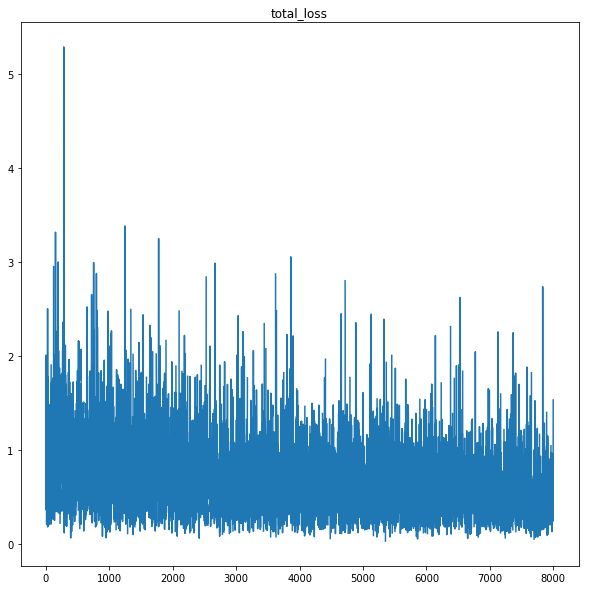

In [10]:
x = np.arange(len(total_loss))[:8000]
y = np.array(total_loss)[:8000]
plt.title('total_loss')
plt.plot(x,y)

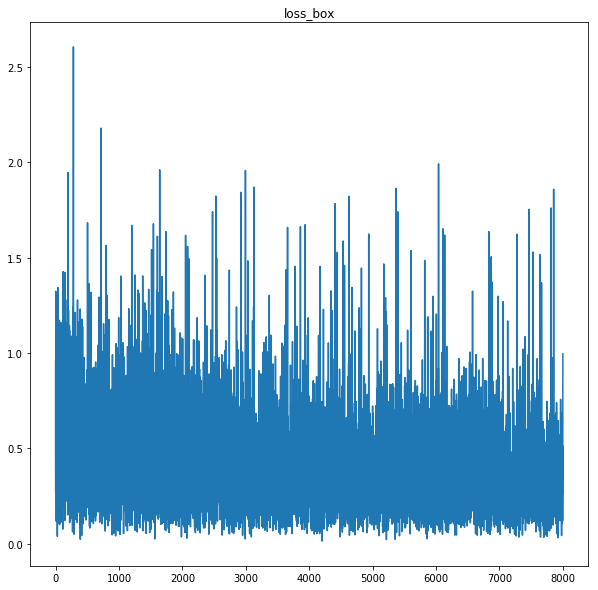

In [11]:
x = np.arange(len(loss_box))[:8000]
y = np.array(loss_box)[:8000]
plt.title('loss_box')
plt.plot(x,y)

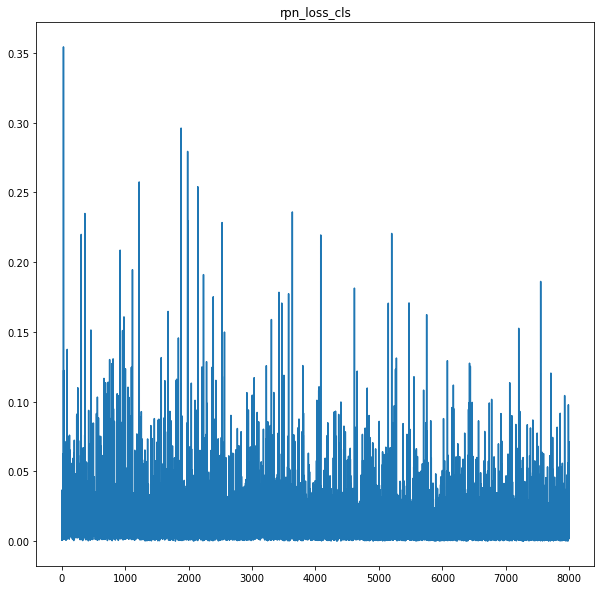

In [12]:
x = np.arange(len(rpn_loss_cls))[:8000]
y = np.array(rpn_loss_cls)[:8000]
plt.title('rpn_loss_cls')
plt.plot(x,y)

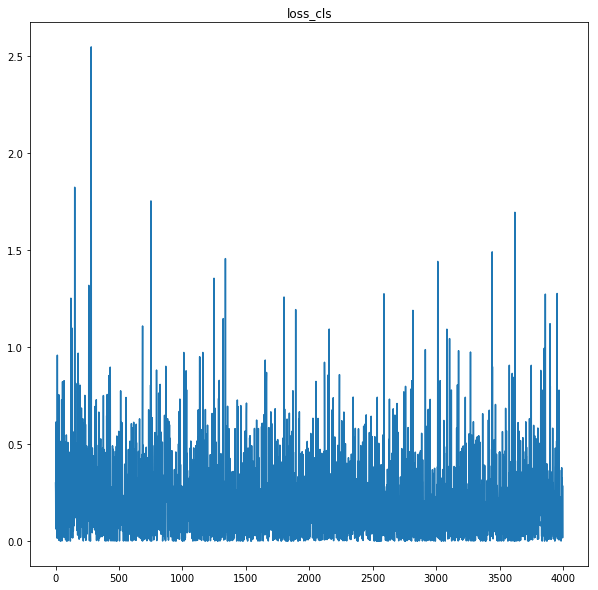

In [14]:
x = np.arange(len(loss_cls))[:4000]
y = np.array(loss_cls)[:4000]
plt.title('loss_cls')
plt.plot(x,y)